<a href="https://colab.research.google.com/github/maytlim/ap157/blob/main/DLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Diffusion-Limited Aggregation

### Examples - Chemistry
<section class="post-meta">
By Jonas Tjemsland, Andreas S. Krogen and Jon Andreas Støvneng
</section>
Last edited: March 22nd 2018 
___

## Introduction

Perhaps the first serious study of Diffusion-Limited Aggregation was made by T.A. Witten and L. M. Sander and published by them in 1981. As the name suggests, the model describes random aggregation, the formation of a number of things into a cluster. This model is amongst other used to describe the diffusion and aggregation of copper ions in an electrolytic solution onto electrodes, as seen in figure 1.

<img src="https://www.numfys.net/media/notebooks/images/DLA_Cluster.JPG" width="400">
**Figure 1:** A diffusion-limited aggregation (DLA) cluster. Copper aggregate formed in an electrodeposition cell. (Source: Kevin Johnson, [wikipedia](https://commons.wikimedia.org/wiki/File:DLA_Cluster.JPG))

Witten and Sander describes their model in the following way [1]:  
*Our model is a variant of the Eden model whose initial state is a seed particle at the origin of a
lattice. A second particle is added at some random site at large distance from the origin. This particle walks randomly until it visits a site adjacent to the seed. Then the walking particle becomes part of the cluster. Another particle is now introduced at a random distant point, and it walks randomly until it joins the cluster, and so forth. If a particle touches the boundaries of the lattice in its random walk it is removed and another introduced.*

Paul Bourke [2] has a more colorful description, involving a city square surrounded by taverns:  
*Drunks leave the taverns and stagger randomly around the square until they finally trip over one their insensate companions at which time, lulled by the sounds of peaceful snoring, they lie down and fall asleep. The tendril like structure is an aerial view of the sleeping crowd in the morning.*



Density correlations within the model aggregates fall off with distance with
a fractional power law and the radius of the aggregation has power-law behavior [1], which coincides with experiments (as the one showed in figure 1). 

As always, we start by including libraries and setting common figure parameters.

In [1]:
%matplotlib inline
import numpy as np
from math import ceil, floor
import matplotlib.pyplot as plt
import progressbar
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import curve_fit

In [2]:
# Set some figure parameters
newparams = {'savefig.dpi': 200, 'figure.figsize': (20, 10), 
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
plt.rcParams.update(newparams)

## The modelling
We will be considering a square lattice, where each position can either contain or not contain a particle. The random walk of the particles may be described as random walk due to [Brownian motion](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/brownian_motion_intro.ipynb): the time evolution of the position of the particle takes the form of discrete steps, and in each step there is an equal probability of the particle moving a distance $h$ in each direction. In two dimensions, the probability that the particle moves *up*, *down*, *left* and *right* has each a probability $1/4$ to occur.

The density is assumed to be so low that the interaction between two (randomly walking) particles is neglible. We may thus consider one particle at a time. The particle becomes a part of the cluster if its position on the square lattice is adjacent to some part of the cluster. In this notebook we will define *adjacent* as *vertical, diagonal or horizontal neighboring points*. That is, each point on the lattice has eight neighboring points. Note that Witten and Sander used only horizontal and vertical neighboring points in their original article. In addition, we will also introduce a so-called *stickiness*, which is the probability that the particle sticks to the cluster at each neighboring point.

Note that the particle theoretically can wander away and we should therefore *do* something with the particles that are *out of range* (either hitting the edge of the lattice or be outside a specified range). There are several ways to do this. One may for example implement periodic boundary conditions (a particle that hits the right of the lattice, or a specific range, emerges on the left, etc.), ignore steps that moves the particles outside the range, or ignore the particle and introduce a new one. These will have about the same visual results [2]. We will be implementing the latter.

In the original model, the particles are said to be introduced at a *distant point*. To lower the computational time, we will be introducing the particles randomly distibuted on a circle that has a radius a bit larger than the maximum radius of the cluster.

One last remark: Scripting languages, such as Python, are quite slow compared to compiled languages such as Fortran and C/C++. Many of the functions in NumPy and SciPy calls compiled modules (see e.g. our guide on [F2PY](https://www.numfys.net/howto/F2PY/)). The DLA model is very computational demanding, and therefore want to make use of these compiled modules. In the function below, we are using NumPy functions to compute a chunck of 200 steps at the time, thus lowering the computational time considerable, but the code may be a bit complex. In the case when the stickiness is less than one, we proceed by computing single steps.

In [3]:
def DLA(particles, seed, stickiness, L=1000, STEP_CHUNCK=200, range_length=100, start_length=10):
    """ Performs the Diffusion Limited Aggregation model on a lattice for a 
    given amount of particles and a given seed. Try to optimize optional arguments!
    Parameters:
        particles:    int. Number of particles.
        seed:         array-like, mxn, m,n < L. Seed.
        stickiness:   float. 'Sticking' probability. Should be in the range [0,1].
        L:            int. Size of the lattice. The lattice will become a (2L+1)x(2L+1).
        STEP_CHUNCK:  int. Specifies the number of steps calculated at once.
        range_length: int. Length at which the particles are considered "out of range".
        start_length: int. Length at which the particles are created.
    Output:
        lattice:     (2L+1)x(2L+1) numpy array. Array describing the cluster. The
                     entries are 0 at empty position and n for the n'th particle.
        max_radius:  float. The maximum radius of the lattice.
    """

    # Define possible steps and adjacent cells
    STEPS = np.array([(0,1), (0,-1), (1,0), (-1,0)])
    ADJACENT = np.array([(0,1), (0,-1), (1,0), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)])

    # Create empty lattice
    lattice_size = 2*L + 1
    lattice = np.zeros((lattice_size, lattice_size), dtype='int32')

    # Create a cluster. That is, a lattice holding all 'adjacent cells'
    cluster = (lattice != 0)
    # Set the seed in the midle of the lattice
    seed = (seed != 0) # Set all entries to one or zero
    seed_size = np.array([np.size(seed,0), np.size(seed,1)])
    l = seed_size/2
    cluster[ceil(L - l[0]):ceil(L + l[0]), ceil(L - l[1]):ceil(L + l[1])] = seed
    # We define the 'start maximal radius' as being the maximal radius of the seed.
    max_radius = (np.size(seed,0)**2 + np.size(seed,1)**2)**.5
    lattice = np.copy(cluster)*particles

    ### Performing the simulation ###
    angles = np.random.rand(particles)*2*np.pi # One random angle per particle

    bar = progressbar.ProgressBar()
    for i in bar(range(particles)):

        # Setting inital position
        x = int((max_radius + start_length)*np.cos(angles[i]) + L)
        y = int((max_radius + start_length)*np.sin(angles[i]) + L)

        while True:
            # Performing one step chunck og STEP_CHUNK number of steps. This idea was inspired by
            # https://github.com/hemmer/pyDLA/blob/numpyFast/dla.py
            steps = np.random.randint(0,4,STEP_CHUNCK)
            steps = np.cumsum(STEPS[steps], axis=0)
            steps[:,0] += x
            steps[:,1] += y 
            # Check at which positions in the chunck the particle is adjacent to the cluster
            adjacent = cluster[steps[:,0], steps[:,1]]

            if np.any(adjacent): # If at least one of the positions are adjacent
                # If the stickiness is 100%, the particle will be stuck at the first adjacent position
                first_hit = adjacent.nonzero()[0][0]
                x = steps[first_hit, 0]
                y = steps[first_hit, 1]
                current_radius = (x - L)**2 + (y - L)**2
                # If not, we should perform only single steps at the time, and only allow steps that
                # does not collide with existing particles. At each adjacent position, there are a
                # probability of sticking. If the particle goes outside the maximum radius of the
                # cluster, we forget about it and introduce a new
                if (stickiness < 1):
                    is_attached = (np.random.rand(1) < stickiness)
                    inside = (current_radius < (max_radius + 2)**2)
                    while ((not is_attached) and inside):
                        while True:
                            r = np.random.randint(1,5)
                            if (r == 1 and (not lattice[x + 1, y])):
                                x += 1
                                break
                            elif (r == 2 and (not lattice[x - 1, y])):
                                x -= 1
                                break
                            elif (r == 3 and (not lattice[x, y + 1])):
                                y += 1
                                break
                            elif (r == 4 and (not lattice[x, y - 1])):
                                y -= 1
                                break
                        if (cluster[x, y]):
                            is_attached = (np.random.rand(1) < stickiness)
                        current_radius = (x - L)**2 + (y - L)**2
                        inside = (current_radius < (max_radius + 2)**2)
                    if (not inside):
                        new_angle = np.random.rand(1)*2*np.pi
                        x = int((max_radius + start_length)*np.cos(new_angle) + L)
                        y = int((max_radius + start_length)*np.sin(new_angle) + L)
                    else:
                        lattice[x, y] = i
                        cluster[ADJACENT[:, 0] + x, ADJACENT[:, 1] + y] = True
                        if (current_radius > max_radius**2):
                            max_radius = current_radius**.5
                        break
                else:
                    # Put the particle number into the lattice at current position,
                    # if it is adjacent to the cluster
                    lattice[x, y] = i
                    # Update adjacent cells
                    cluster[ADJACENT[:, 0] + x, ADJACENT[:, 1] + y] = True
                    # Update the cluster radius
                    if (current_radius > max_radius**2):
                        max_radius = current_radius**.5
                    break

            else:
                x = steps[-1,0]
                y = steps[-1,1]
                # If the last posision in the chunck is out of range, then introduce a new particle
                current_radius = (x - L)**2 + (y - L)**2
                if (current_radius > (max_radius + range_length)**2):
                    new_angle = np.random.rand(1)*2*np.pi
                    x = int((max_radius + start_length)*np.cos(new_angle) + L)
                    y = int((max_radius + start_length)*np.sin(new_angle) + L)
    return lattice, max_radius

Let us start by performing the simulation with, say 10000 particles and a single point as seed, for different stickiness. We also want to crop (remember that the lattice should be much larger than the radius of the cluster) and plot the results.

In [4]:
def DLA_sim(particles=10000, stickiness=1, seed=np.ones((1,1))):
    """ Calls DLA() and visualizes the results.
    Parameters: Same as DLA()
    Output:
        lattice_gray_cut: numpy array. Cropped array describing the cluster. The
                          entries are 0 at empty position and n for the n'th particle.
        lattice_cut:      numpy array. Cropped array describing the cluster. The
                          entries are 0 at empty position and 1 otherwise.
        max_radius:       float. The maximum radius of the lattice.
    """
    # Perform simulation
    lattice, max_radius = DLA(particles, seed, stickiness)
    # Create a corresponding black/white lattice
    lattice_gray = (lattice != 0)
    # Crop
    mask = np.ix_(lattice_gray.any(1),lattice_gray.any(0)) # Create a 'crop mask'
    lattice_gray_cut = lattice_gray[mask]
    lattice_cut = lattice[mask]
    print("Maximum radius: ", max_radius)
    # Plot results
    plt.figure()
    plt.suptitle("DLA-cluster with %d particles and stickiness %.2f" % (particles, stickiness))
    plt.subplot(121)
    plt.imshow(lattice_cut, interpolation='none')
    plt.subplot(122)
    plt.imshow(lattice_gray_cut, interpolation='none', cmap='gray')
    plt.show()
    return lattice_gray_cut, lattice_cut, max_radius

100% (10000 of 10000) |##################| Elapsed Time: 0:01:05 Time:  0:01:05


Maximum radius:  298.46440323763903


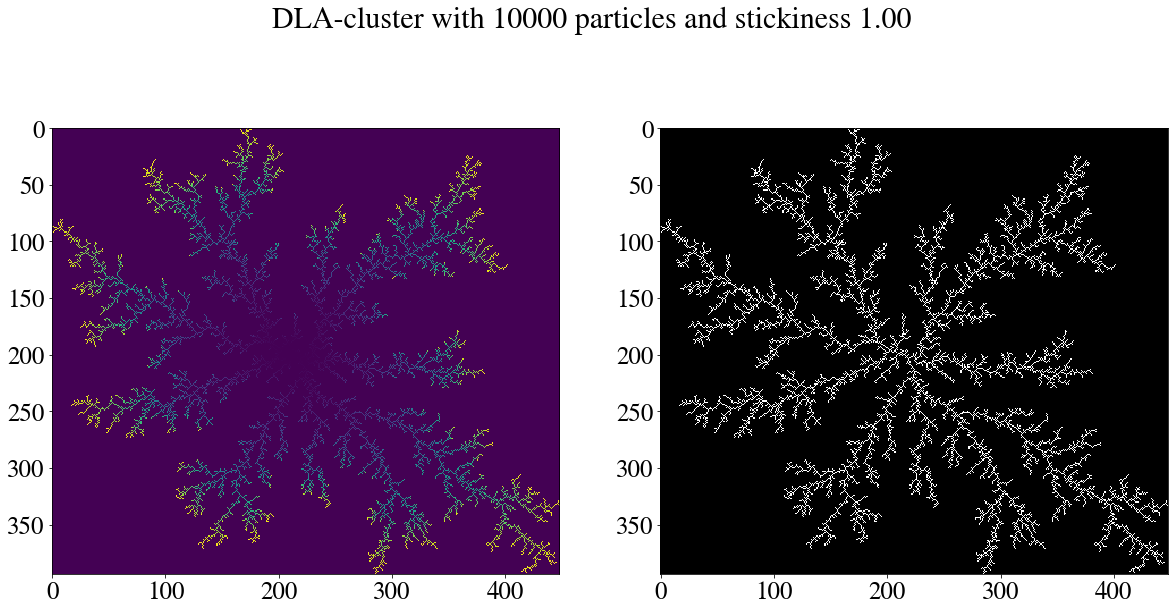

100% (10000 of 10000) |##################| Elapsed Time: 0:00:48 Time:  0:00:48


Maximum radius:  232.29722340140012


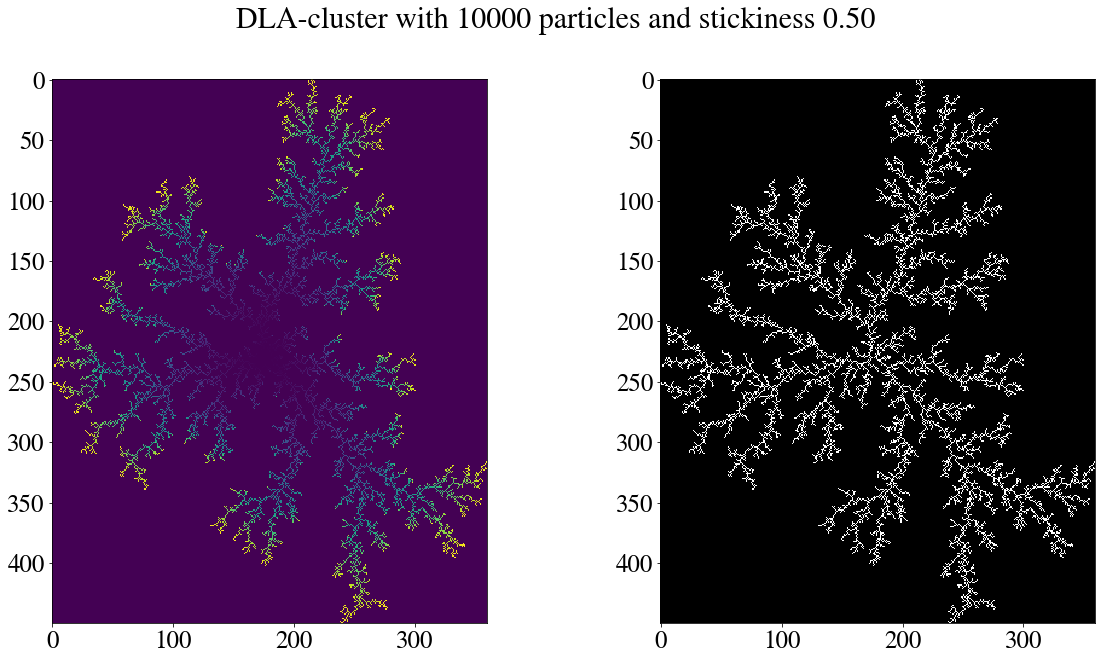

100% (10000 of 10000) |##################| Elapsed Time: 0:00:24 Time:  0:00:24


Maximum radius:  140.61649974309557


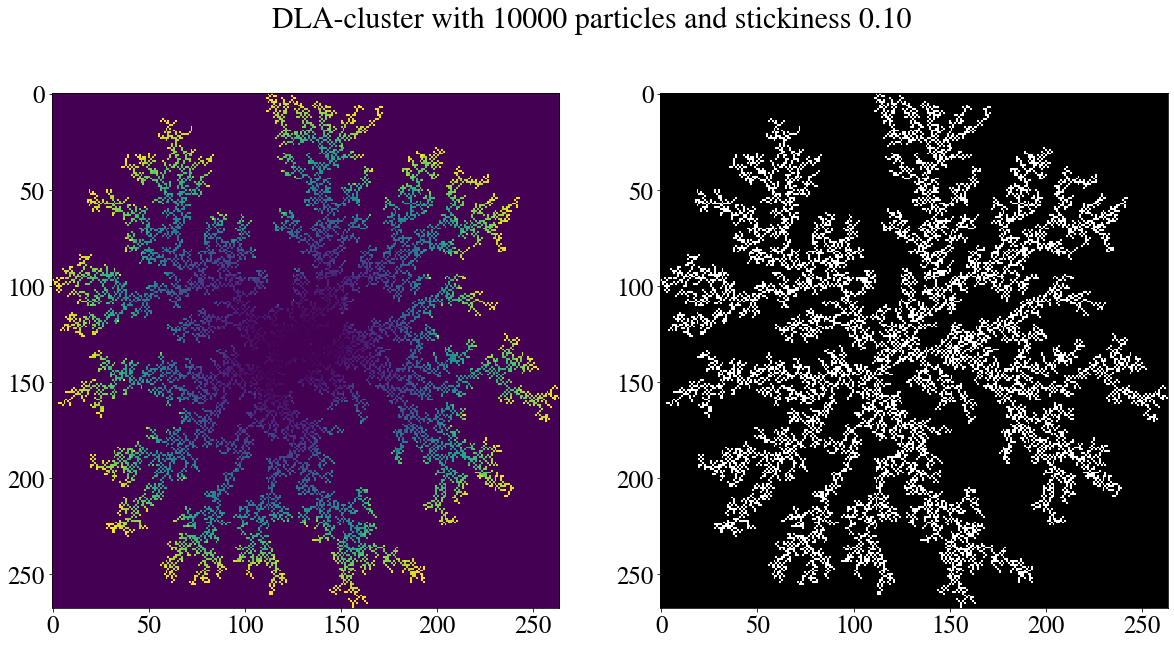

In [5]:
lattice = DLA_sim(stickiness=1.00)
DLA_sim(stickiness=0.50);
DLA_sim(stickiness=0.10);

On the left image one can clearly see that new particles often stick to the cluster on the periphery. Its structure is easily seen on the right image. With a lower sticking probability the radius is decreased. That is, the structure becomes more compact, and the 'arms' more 'hairy'. As we will see, lower stickiness gives a lower fractal dimension $D$.

It is quite similar to figure 1, and the result in the article!

## Fractals
In many ways these clusters resemble so-called fractals, a mathematical set that exhibits a repeating pattern displayed at every scale [3]. One example of a fractal is shown in figure 2 below. This fractal is actually made using a quite simple method called *iterated function systems (IFSs)* with only a few input parameters [4]. By changing these parameters one can create many famous and artistic fractals. 

By looking at the figure, can you convince yourself that fractals are found in nature? Some phenomena known to have fractal features include river networks, mountain ranges, lightning bolts, trees, mountain goat horns, algae, geometrical optics, animal coloration patterns, crystals and DNA! [3]

![Barsley Fern fractal](https://www.numfys.net/media/notebooks/images/barnsley-fern-fractal.png)
**Figure 2** The Barsley Fern fractal, created using Python [5]

Note how one branch in figure 2 branches out into many smaller branches. Each of these in turn resembles the *parent branch*. This is also the case for our DLA clusters!

## Fractal dimension

Fractals have a finite area, but an infinite perimeter. Consider our DLA clusters: Using a large measuring stick, we would not reach between the branches, but using a small measuring stick we would. In this manner, fractals cannot be described by the means of usual Euclidian dimensions, they have in general a non-integer fractal dimension $D$. This tells ut something about how dense the fractal is. Theoretically, the fractal dimension of a DLA cluster is $D \approx 1.71$. However, this is only true when the particles are not confined to a lattice.

Assume that a $d$-dimensional fractal is covered by a set of $d$-dimentional shapes (e.g. spheres or boxes in two dimensions) of linear size $\epsilon$ (an $L\times L$ square will have $\epsilon\propto L$, and we may choose $\epsilon = L$. For a sphere, we may for example choose $\epsilon$ to be the radius or the diameter of the sphere, or even the circumference! It is the scaling that is important).  Then, the number of such shapes will scale as
$$N \sim \epsilon^{-d}$$
[6]. In Euclidean space, $D$ is always an integer. This equation can be written as
$$D \equiv -\frac{\log N(\epsilon)}{\log \epsilon}.$$

There are several ways to estimate the fractal dimension of our discrete DLA cluster. Witten and Sander [1] used the density correlation function to analyze the density. They found that $\rho = -0.34$, which in turn can be shown that corresponds to a fractal dimension of $D=1.66$. In this notebook we will rather use the more intuitive box counting algorithm. Note that this is no exact science: we will always expect $D$ less that the theoretical $1.71$, and maybe even lower than $1.66$!

## The box counting algorithm
We will now approximate the fractal dimension using the box counting algorithm. The idea is quite simple: We choose a box of size $\epsilon$, cover the cluster in these boxes and count how many of these boxes contains at least one particle. Then we check how the the number of boxes $N$ scales with the size $\epsilon$. This approximates the *box counting dimension*
$$D \equiv \lim_{\epsilon \to 0}\frac{\log N(\epsilon)}{\log (1/\epsilon)}.$$
Note again that $\epsilon$ is scaled as the box, and is not necessarily equal to the length of the size of the boxes!

In [6]:
def box(n, lattice):
    """ Divide lattice into boxes and count how many that has
    a positive sum of entries. The boxes are Lx/n x Ly/n, where
    the lattice is an (Lx, Ly)-array.
    Parameter:
        n:         int. Division fraction.
        lattice:   array-like, 2D. The cluster being analyzed. Should be 
                   cropped to maximize performance.
    Returns:
        num:       int. Number of boxes with a positive sum of entries.
    """
    L = [np.size(lattice,0), np.size(lattice,1)]
    Nx = int(L[0]/n)
    Ny = int(L[1]/n)
    num = 0
    for i in range(Nx):
        for j in range(Ny):
            contained = np.sum(lattice[int(i*n):int(i*n+n),int(j*n):int(j*n+n)])
            if (contained):
                num += 1
    for i in range(Nx):
        contained = np.sum(lattice[int(i*n):int(i*n+n), int(Ny*n):int(L[1]+1)])
        if (contained):
            num += 1
    for i in range(Ny):
        contained = np.sum(lattice[int(Nx*n):int(L[1]+1), int(i*n):int(i*n+n)])
        if (contained):
            num += 1
    contained = np.sum(lattice[int(Nx*n):int(L[0]+1), int(Ny*n):int(L[1]+1)])
    if (contained):
        num += 1
    return num

def paket(lattice, start_potent=1, end_potent=7, num_points=20):
    """ Calls box() repeatedly with different box sizes, exponentially distibuted.
    Parameters:
        lattice:      array-like, 2D. The cluster being analyzed. Should be 
                      cropped to maximize performance.
        start_potent: int. Size of the first box as a fraction of the lattice.
        end_potent:   int. Size of the last box as a fraction of the lattice.
        num_points:   int. Number of calls to box() with n logarithmically
                      distibuted between start_potent and end_potent.
    Return:
        X:            1xnum_points numpy array. Linear box size.
        Y:            1xnum_points array. Number of boxes that contains at least a particle.
    """
    L = np.size(lattice,0)
    X = np.logspace(start_potent, end_potent, num=num_points, endpoint=True, base=2)
    Y = []
    for i in range(len(X)):
        Y.append(box(X[i],lattice))
    return X, Y

Now we simply call the functions above for one of our clusters, perform regression and plot the result!

Fractal dimension: D = 1.53


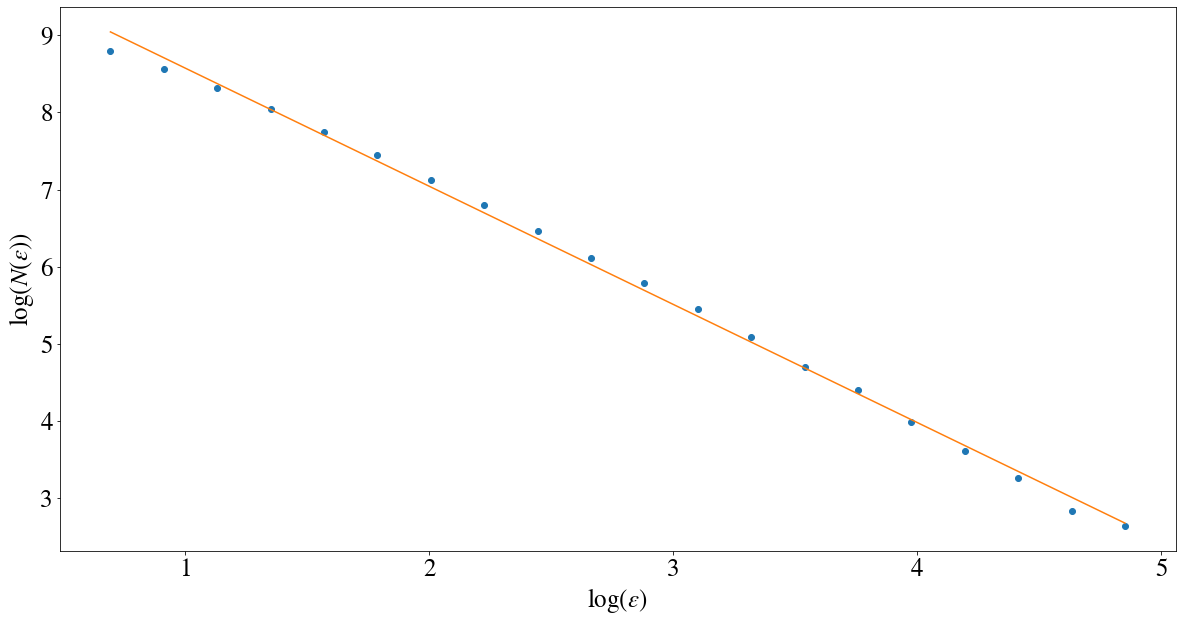

In [7]:
X, Y = paket(lattice[0], 1, 7, 20)
x = np.log(X)
y = np.log(Y)
coeff = np.polyfit(x, y, 1)
print("Fractal dimension: D = %.2f" % -coeff[0])

plt.figure()
plt.plot(x,y,'o')
xi = np.array([min(x), max(x)])
plt.plot(xi, coeff[0]*xi + coeff[1])
plt.xlabel("$\log(\epsilon)$")
plt.ylabel("$\log(N(\epsilon))$")
plt.show()

## Play around with different seeds!

100% (5000 of 5000) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


Maximum radius:  207.7137453323684


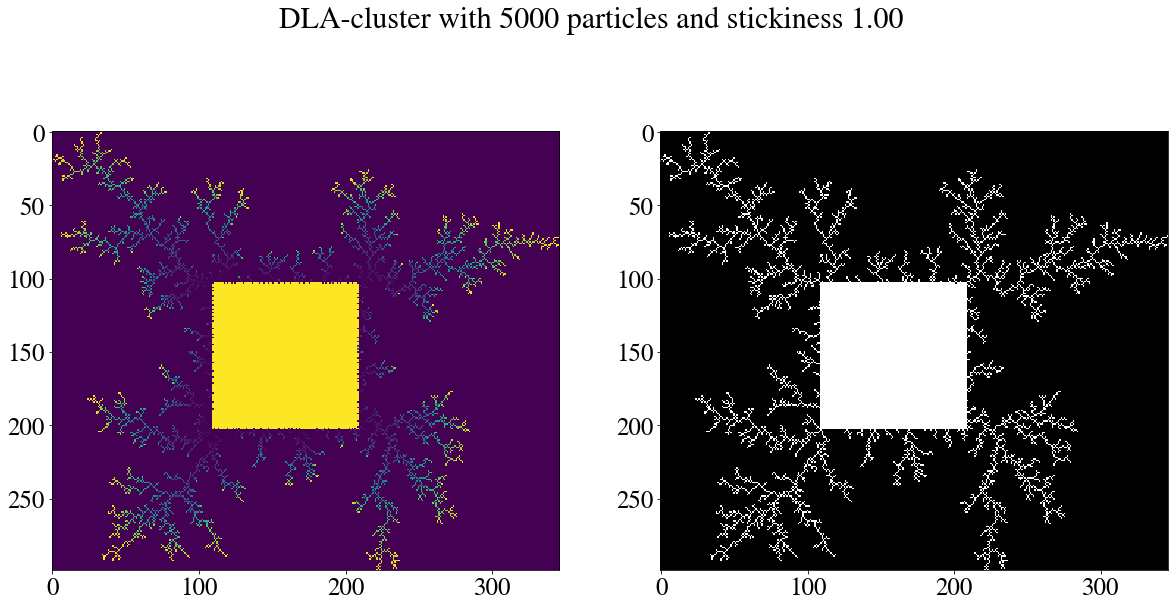

In [8]:
particles = 5000
seed = np.ones((100,100))
DLA_sim(particles=particles, seed=seed);

100% (5000 of 5000) |####################| Elapsed Time: 0:00:26 Time:  0:00:26


Maximum radius:  199.12307751739877


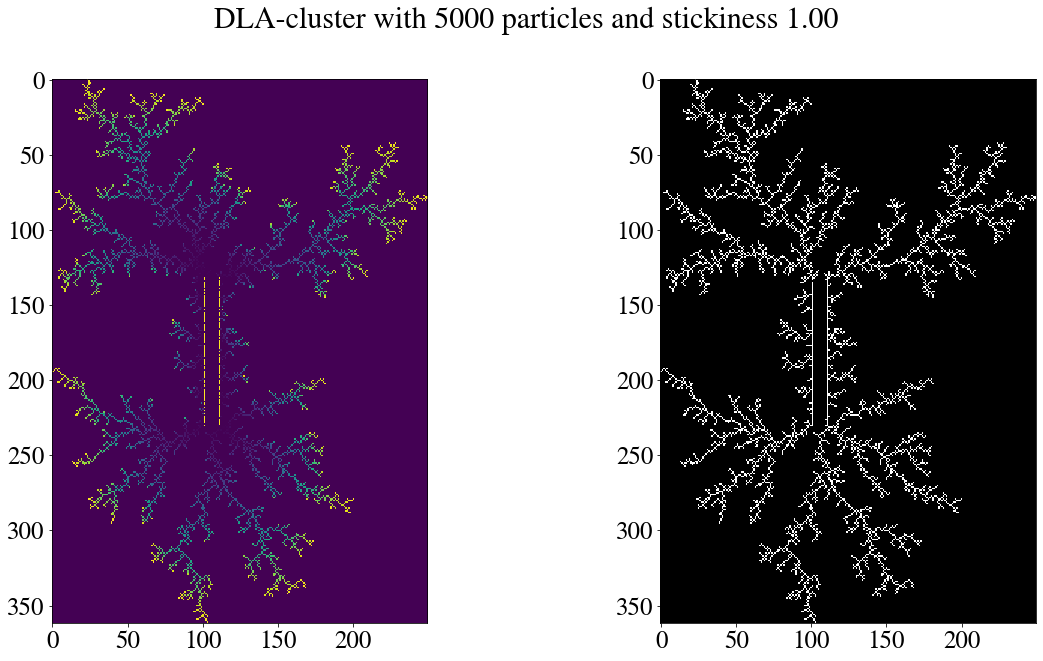

In [9]:
seed = np.zeros((100,20))
seed[:,5] = 1
seed[:,-5] = 1
DLA_sim(particles=5000, seed=seed);

### References

[1] [T. A. Witten Jr, L. M. Sander, Phys. Rev. Lett. 47, 1400 (1981)](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.47.1400)  
[2] P. Bourke: Diffusion Limited Aggregation, http://paulbourke.net/fractals/dla/, June 1991 [acquired: 01.10.2017]  
[3] Wikipedia: Fractal, https://en.wikipedia.org/wiki/Fractal [acquired: 01.26.2017]  
[4] Wikipedia: Iterated Funtion System (IFS), https://en.wikipedia.org/wiki/Iterated_function_system [acquired: 01.26.2017]  
[5] ActiveState code, by user FB26, http://code.activestate.com/recipes/578003-ifs-fractals-using-iteration-method/, 01.07.2012 [acquired: 01.26.2017]   
[6] Wikipedia: Fractal Dimension, https://en.wikipedia.org/wiki/Fractal_dimension [acquired: 01.26.2017]  